In [1]:
!pip install yfinance
!pip install tensorflow
!pip install matplotlib

[*********************100%***********************]  1 of 1 completed

Fetched data for AAPL with additional features.
Epoch 1/50


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0130 - mae: 0.0773 - mse: 0.0130 - val_loss: 0.0081 - val_mae: 0.0669 - val_mse: 0.0081 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0022 - mae: 0.0326 - mse: 0.0022 - val_loss: 0.0044 - val_mae: 0.0500 - val_mse: 0.0044 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0013 - mae: 0.0241 - mse: 0.0013 - val_loss: 0.0053 - val_mae: 0.0550 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0014 - mae: 0.0230 - mse: 0.0014 - val_loss: 0.0021 - val_mae: 0.0338 - val_mse: 0.0021 - learning_rate: 0.0010
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0012 - mae: 0.0216 - mse: 0.0012 - val_loss: 0.0019 - val_mae: 0.0343 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0012 - mae: 0.0231 - mse: 0.0012 - val_loss: 0.0107 - val_mae: 0.0907 - val_mse: 0.0

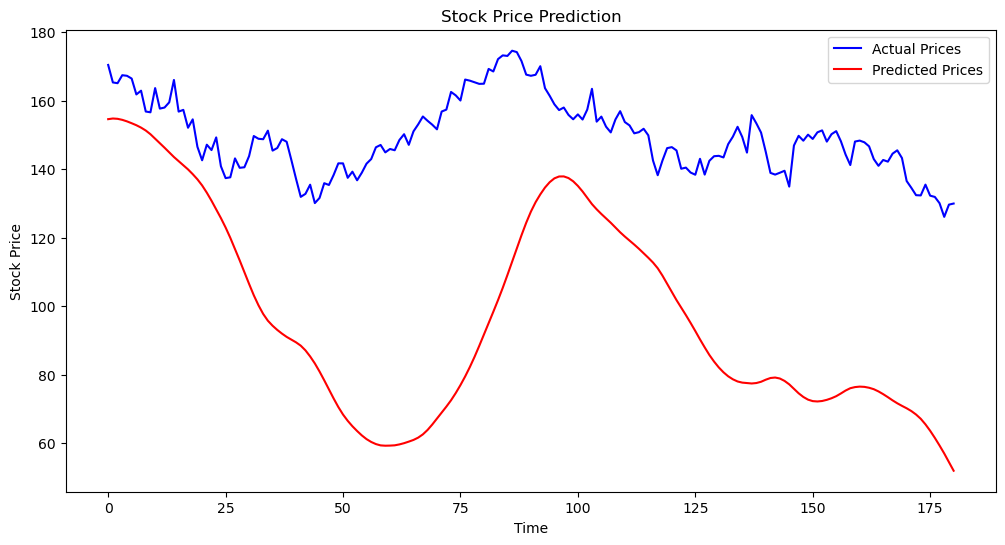

Root Mean Squared Error (RMSE): 61.42234159744253
Mean Absolute Percentage Error (MAPE): 35.82%


In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

# Fetch historical stock data with additional features
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['RSI'] = calculate_rsi(data['Close'])
    data['Bollinger_Upper'], data['Bollinger_Lower'] = calculate_bollinger_bands(data['Close'])
    data = data.dropna()  # Remove rows with NaN values
    return data

# Calculate RSI (Relative Strength Index)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate Bollinger Bands
def calculate_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

# Preprocess the data for LSTM
def preprocess_data(data, lookback=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, :])
        y.append(scaled_data[i, 0])  # Predicting 'Close' price
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Build model with Attention Mechanism
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Layers
    x = LSTM(units=128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    
    # Attention Mechanism
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    x = LSTM(units=32, return_sequences=False)(x)
    x = Dropout(0.3)(x)
    
    # Dense Layers
    x = Dense(units=32, activation='relu')(x)
    outputs = Dense(units=1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

# Plot predictions vs actual data
def plot_predictions(actual, predicted, title="Stock Price Prediction"):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predicted, color='red', label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Main function
if __name__ == "__main__":
    # Parameters
    ticker = "AAPL"
    start_date = "2015-01-01"
    end_date = "2023-01-01"
    lookback_period = 60

    # Fetch data
    data = fetch_data(ticker, start_date, end_date)
    features = data[['Close', 'MA_20', 'MA_50', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower']]
    print(f"Fetched data for {ticker} with additional features.")

    # Train-test split
    train_size = int(len(features) * 0.87777777)
    train_data, test_data = features[:train_size], features[train_size:]

    X_train, y_train, scaler = preprocess_data(train_data, lookback_period)
    X_test, y_test, _ = preprocess_data(test_data, lookback_period)

    # Build the model
    model = build_model((X_train.shape[1], X_train.shape[2]))

    # Callbacks for learning rate reduction and early stopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Increased epochs
        batch_size=32,  # Reduced batch size for precision
        validation_split=0.2,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1)))))[:, 0]
    actual_prices = test_data.iloc[lookback_period:]['Close'].values

    # Plot results
    plot_predictions(actual_prices, predictions)

    # Evaluate model
    rmse = np.sqrt(np.mean((predictions - actual_prices) ** 2))
    mape = mean_absolute_percentage_error(actual_prices, predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")


In [10]:
pip install nsepy

In [4]:
from nsepy import get_history
import datetime
from time import sleep

# Retry logic for robust data fetching
def fetch_data_with_retries(symbol, start, end, retries=3, delay=5):
    # Convert start and end to datetime.date objects
    start = datetime.datetime.strptime(start, "%Y-%m-%d").date()
    end = datetime.datetime.strptime(end, "%Y-%m-%d").date()
    
    for attempt in range(retries):
        try:
            return get_history(symbol=symbol, start=start, end=end)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            sleep(delay)
    raise Exception("Failed to fetch data after multiple retries")

# Usage
try:
    data = fetch_data_with_retries('TCS', '2023-01-01', '2023-12-31')
    print(data.head())
except Exception as e:
    print("Error fetching data:", e)


Empty DataFrame
Columns: [Symbol, Series, Prev Close, Open, High, Low, Last, Close, VWAP, Volume, Turnover, Trades, Deliverable Volume, %Deliverble]
Index: []


In [5]:
pip install --upgrade nsepy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import yfinance as yf

data = yf.download("TCS.NS", start="2023-01-01", end="2023-12-31")
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price         Adj Close        Close         High          Low         Open  \
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS       TCS.NS   
Date                                                                          
2023-01-02  3167.365967  3261.449951  3266.850098  3235.199951  3261.000000   
2023-01-03  3215.827148  3311.350098  3320.000000  3245.300049  3252.000000   
2023-01-04  3219.031494  3314.649902  3327.350098  3286.199951  3306.699951   
2023-01-05  3215.583740  3311.100098  3337.300049  3281.949951  3330.199951   
2023-01-06  3118.906006  3211.550049  3301.550049  3200.000000  3300.000000   

Price        Volume  
Ticker       TCS.NS  
Date                 
2023-01-02   709547  
2023-01-03  1245178  
2023-01-04  1231668  
2023-01-05  1826057  
2023-01-06  2488376  


In [7]:
pip install nsepy==0.8


Note: you may need to restart the kernel to use updated packages.


import yfinance as yf
import pandas as pd

# Fetch historical stock data
def fetch_yfinance_data(symbol, start_date, end_date):
    data = yf.download(f"{symbol}.NS", start=start_date, end=end_date)
    # Clean and format the data as needed
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Usage
symbol = "TCS"
start_date = "2020-01-01"
end_date = "2023-01-01"
try:
    stock_data = fetch_yfinance_data(symbol, start_date, end_date)
    print(stock_data.head())
except Exception as e:
    print("Error fetching data:", e)

In [8]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Assuming 'data' is a DataFrame loaded from a CSV or similar source

# Check if data is empty
if data.empty:
    print("Error: The 'data' DataFrame is empty. Please ensure correct data loading.")
    exit()

# Check if preprocessing removes all data points
print("Data shape before feature creation:", data.shape)
stock_data = create_features(data.copy())  # Use a copy to avoid modifying original data
print("Data shape after feature creation:", stock_data.shape)

# Extract features and target variable
X = stock_data[features]
y = stock_data['Target']

# Check if X and y are empty (optional)
if X.empty or y.empty:
    print("Error: Features (X) or target variable (y) are empty. Check data extraction.")
    exit()

# Train-test split with potential size check (adjust as needed)
if (len(X) > 10):  # Only split if we have enough data (adjust threshold)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=63)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
else:
    print("Warning: Not enough data for train-test split. Consider adjusting parameters or data collection.")

Data shape before feature creation: (245, 6)


NameError: name 'create_features' is not defined